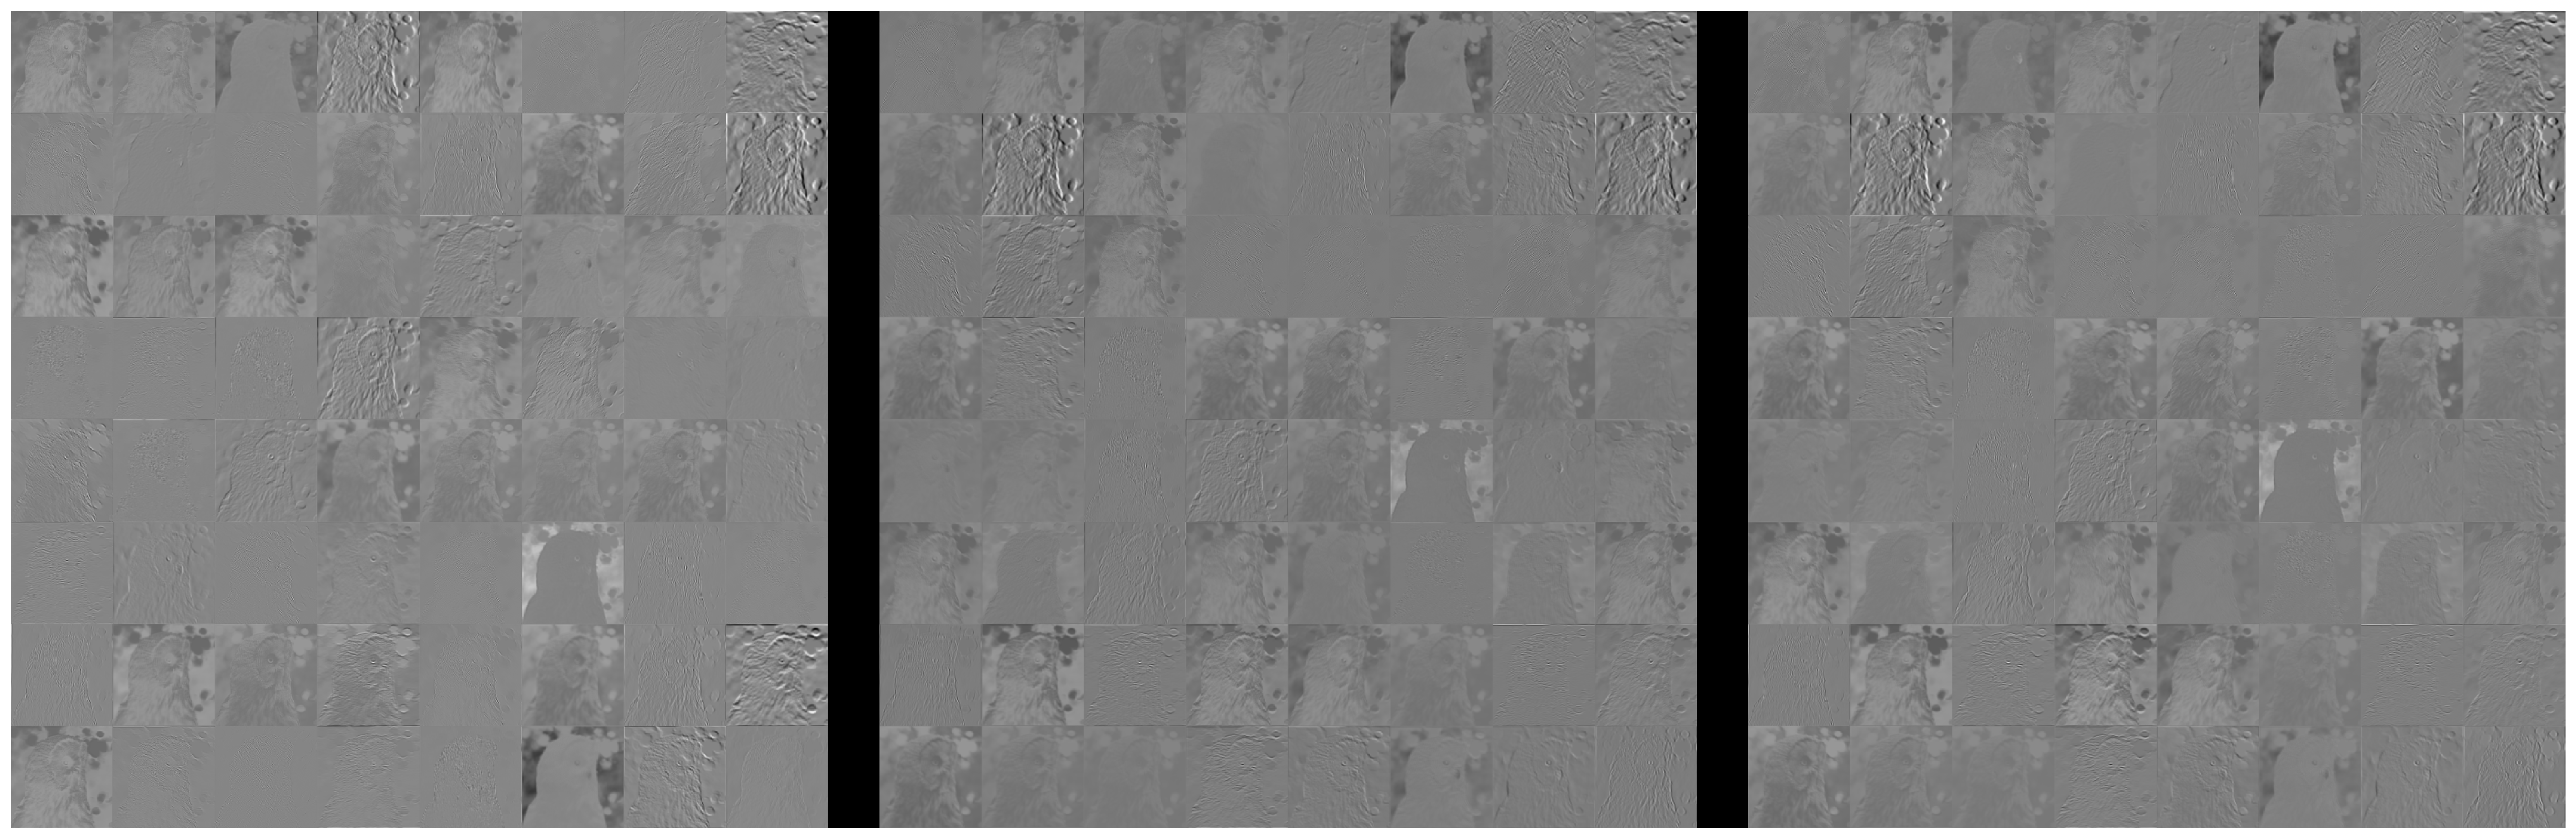

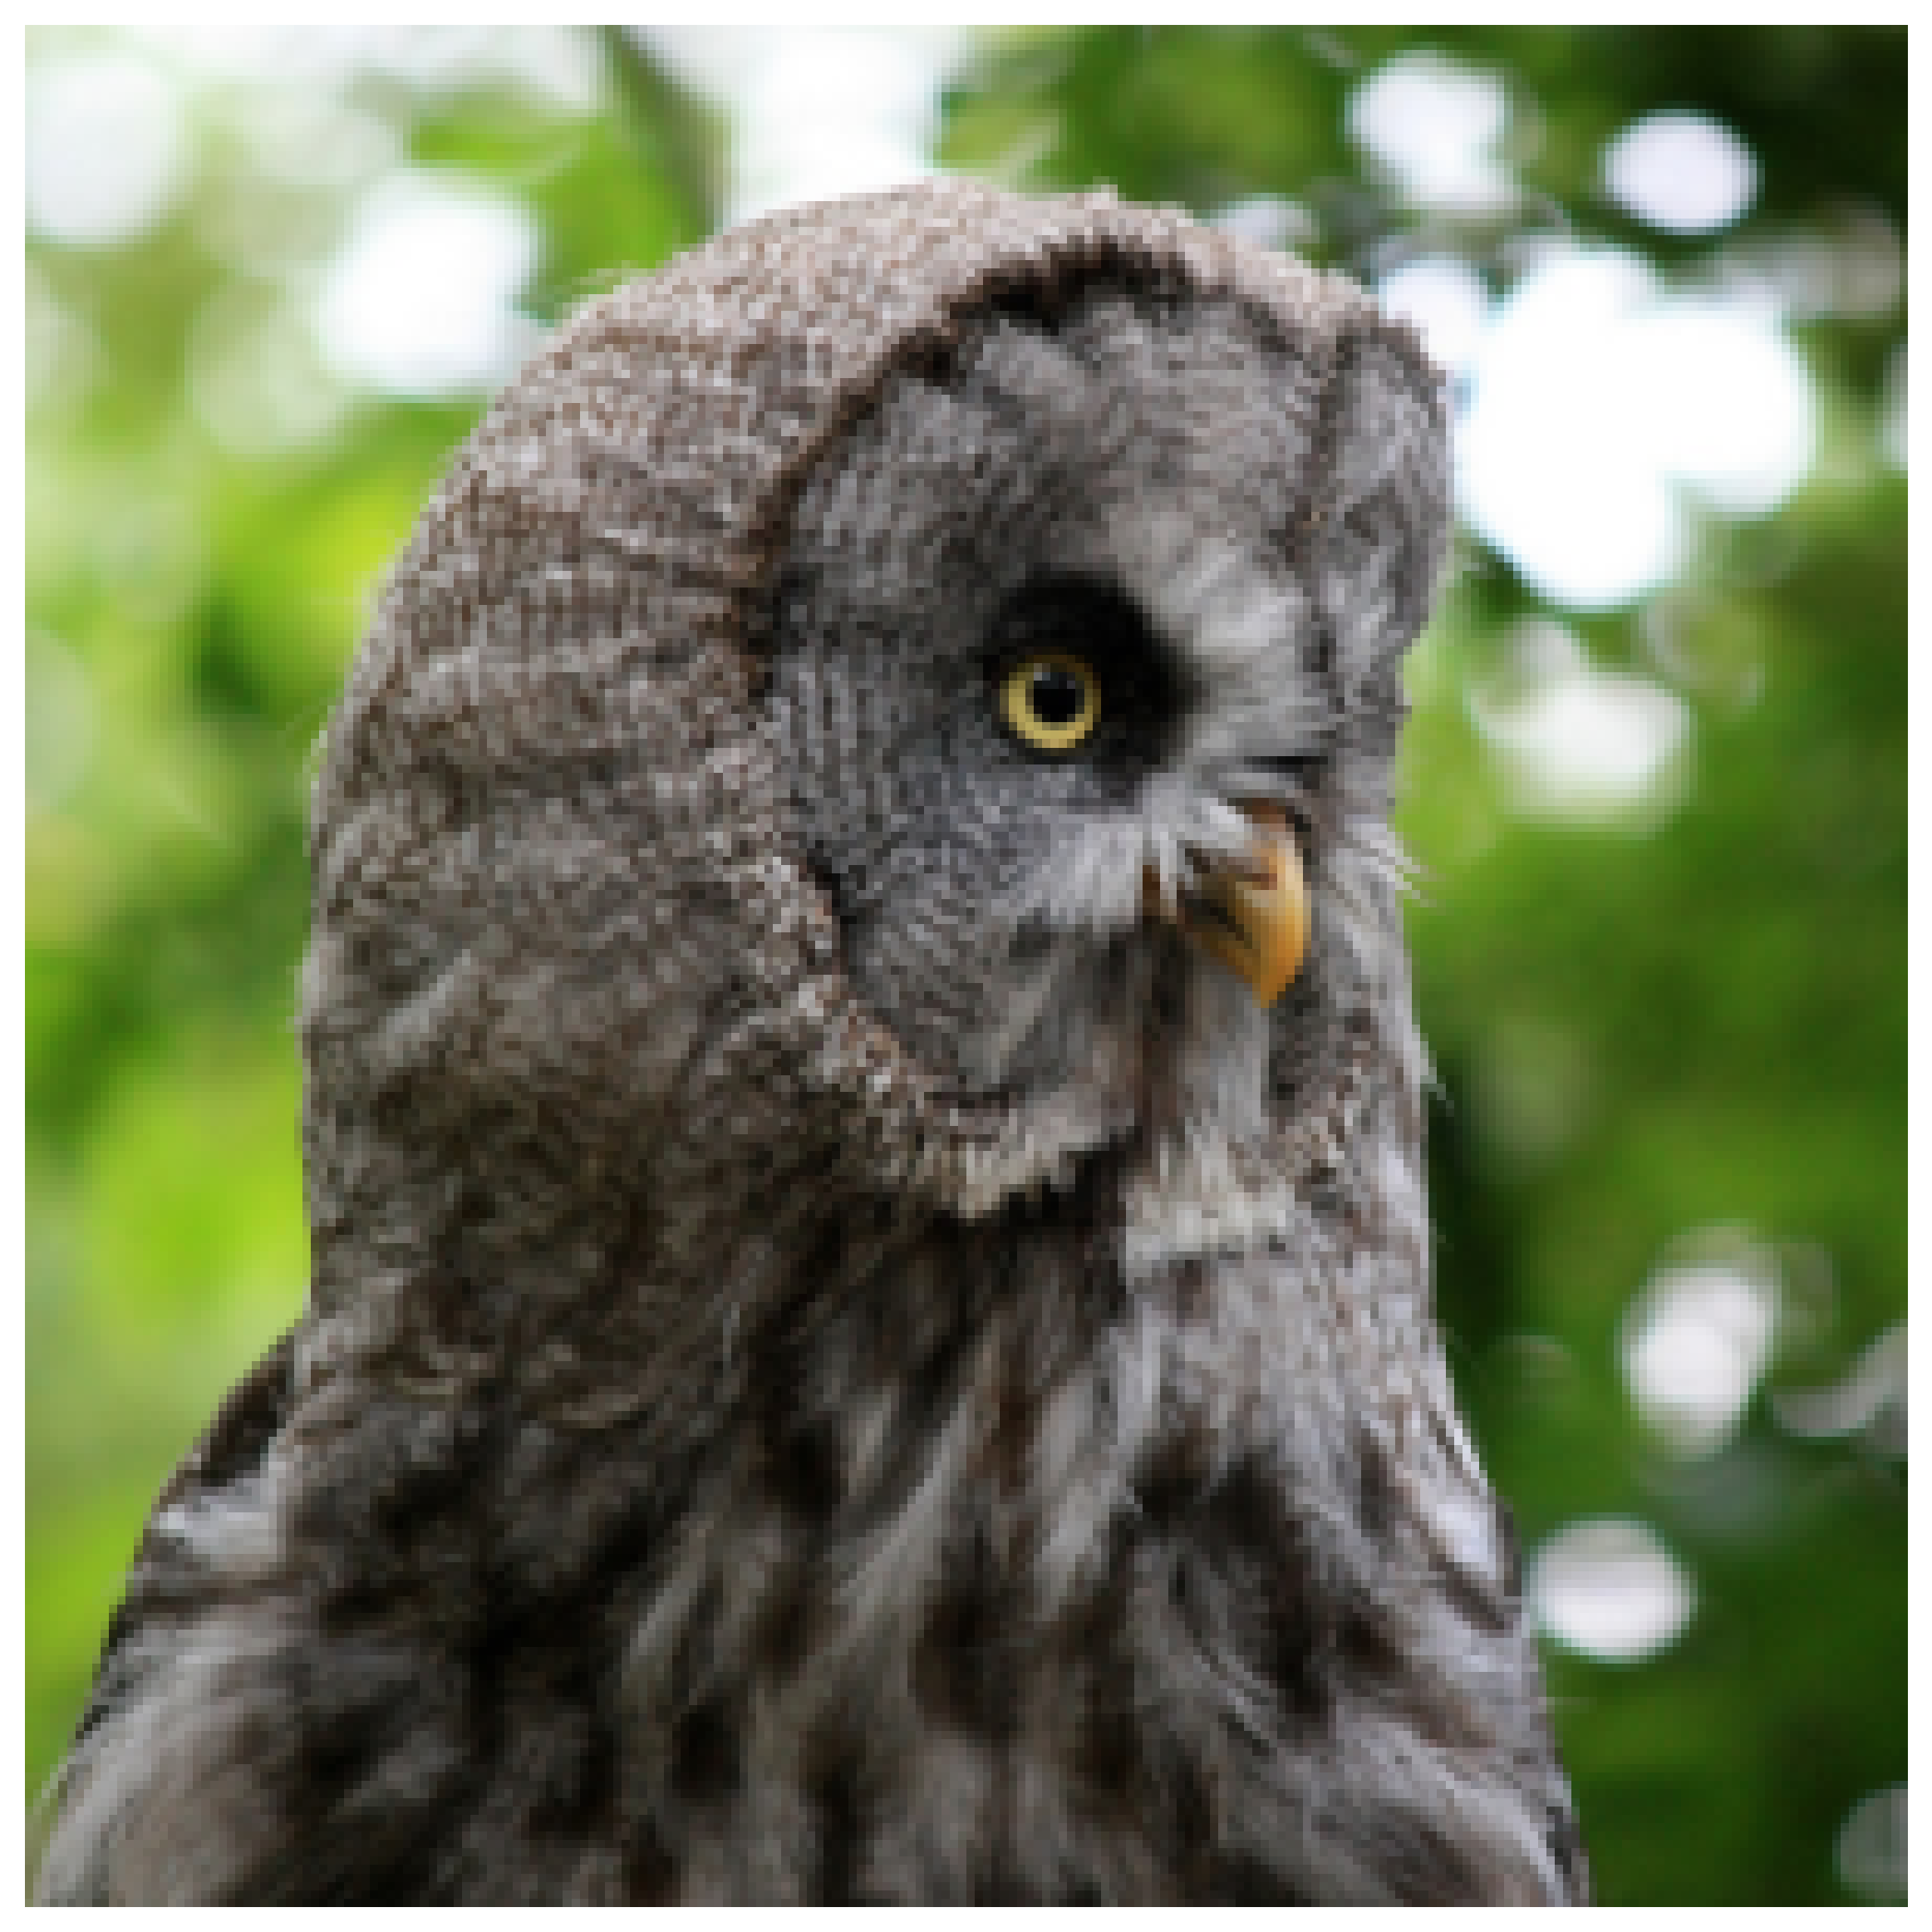

In [1]:
from __future__ import print_function
import sys
sys.path.append("..")
from util.util import lr_scheduler
from datasets.es_imagenet import ESImagenet_Dataset
import LIAF
from LIAFnet.LIAFResNet import *

import torchvision
import torchvision.transforms as transforms
import torch.distributed as dist 
import torch.nn as nn
import argparse, pickle, torch, time, os,sys
from importlib import import_module

import matplotlib.pyplot as plt # plt 用于显示图片
import matplotlib.image as mpimg # mpimg 用于读取图片
import matplotlib

LIAF.BaseNeuron.save_featuremap = True
THRESH = 0.18

#DVS dataset in DVS-format (from {pos:[],neg:[]} to [x,y,t,p]
# from RGB-img 2 dvs

import numpy as np
from torch.nn import functional as F

def _imge2ES(rgbimg):
    tracex = [1,0,2,1,0,2,1,1,2]
    tracey = [0,2,1,0,1,2,0,1,1]

    def traceX(t):
        x = tracex[t]
        return x

    def traceY(t):
        y = tracey[t]
        return y

    count = 0
    aimsize = 254
    pulse = list([])
    imagetorch = rgbimg
    imagetorch = imagetorch.unsqueeze(0)
    a = imagetorch.shape[2]
    b = imagetorch.shape[3]
    if (a>b):
        image = F.interpolate(imagetorch, size = (aimsize,(int)(b*aimsize/a)), mode = 'nearest')
        b = (int)(b*aimsize/a)
        a = aimsize
    else:
        image = F.interpolate(imagetorch, size = ((int)(a*aimsize/b),aimsize), mode = 'nearest')
        a = (int)(a*aimsize/b)
        b = aimsize
    image = image[0].type(torch.FloatTensor)
    imageInfo ,_ = torch.max(image,dim=0)
    imageShape0 = (imageInfo.size()[0], imageInfo.size()[1])

    imageInfo1 = torch.ones(imageShape0[0],imageShape0[1])
    imageShape = (imageInfo.size()[0]+4,imageInfo.size()[1]+4)

    lastImage = torch.zeros(imageShape)
    newImage = torch.zeros(imageShape)
    torch1 = torch.ones([imageShape[0],imageShape[1]])
    torch0 = torch.zeros_like(torch1)
    imageStorep = torch.ones([0,3])
    imageStoren = torch.ones([0,3])
    elen = 0
    for t in range(9):
        newImage = torch.zeros(imageShape).type(torch.FloatTensor)
        x = traceX(t)
        y = traceY(t)
        x0 =traceX(t-1)
        y0 = traceY(t-1)
        newImage[x:x+imageShape0[0],y:y+imageShape0[1]] = imageInfo      
        if t != 0:
            diffImage = newImage - lastImage
            diffImageInfo1 = torch.where(diffImage > THRESH, torch1 , torch0)
            diffImageInfo2 = torch.where(diffImage < -THRESH, torch1 , torch0)
            diffImageInfo1[x:x0,:] = 0
            diffImageInfo1[x0:x,:] = 0
            diffImageInfo1[x+imageShape0[0]:x0+imageShape0[0],:] = 0
            diffImageInfo1[x0+imageShape0[0]:x+imageShape0[0],:] = 0
            diffImageInfo1[:,y:y0] = 0
            diffImageInfo1[:,y0:y] = 0
            diffImageInfo1[:,y+imageShape0[1]:y0+imageShape0[1]] = 0
            diffImageInfo1[:,y0+imageShape0[1]:y+imageShape0[1]] = 0
            diffImageInfo2[x:x0,:] = 0
            diffImageInfo2[x0:x,:] = 0
            diffImageInfo2[x+imageShape0[0]:x0+imageShape0[0],:] = 0
            diffImageInfo2[x0+imageShape0[0]:x+imageShape0[0],:] = 0
            diffImageInfo2[:,y:y0] = 0
            diffImageInfo2[:,y0:y] = 0
            diffImageInfo2[:,y+imageShape0[1]:y0+imageShape0[1]] = 0
            diffImageInfo2[:,y0+imageShape0[1]:y+imageShape0[1]] = 0
            imageStore1 = torch.nonzero(diffImageInfo1,as_tuple=False)    
            x = imageStore1[:,0]
            y = imageStore1[:,1]
            good_xy = (x < 240) & (x > 16) & (y < 240) & (y > 16)
            imageStore1 = imageStore1[good_xy,:]
            timeStore1 = torch.zeros([imageStore1.size()[0],1]).fill_(t)
            imageStore1 = torch.cat((imageStore1,timeStore1),1)
            imageStorep = torch.cat((imageStorep,imageStore1),0) 
            imageStore2 = torch.nonzero(diffImageInfo2,as_tuple=False)
            x = imageStore2[:,0]
            y = imageStore2[:,1]
            good_xy = (x < 240) & (x > 16) & (y < 240) & (y > 16)
            imageStore2 = imageStore2[good_xy,:]
            timeStore2 = torch.zeros([imageStore2.size()[0],1]).fill_(t)
            imageStore2 = torch.cat((imageStore2,timeStore2),1)
            imageStoren = torch.cat((imageStoren,imageStore2),0) 
            elen+= (imageStore1.size()[0]+imageStore2.size()[0])
        lastImage = newImage
        
        
    return imageStorep.type(torch.uint8),imageStoren.type(torch.uint8),a,b

def _ES2frame(p,n,a,b):
    
    dy = (254 - b) // 2
    dx = (254 - a) // 2
    data = torch.zeros([2,8,256, 256])
    x = p[:,0]+ dx
    y = p[:,1]+ dy
    t = p[:,2]-1
    data[0,t ,x ,y ] = 1
    x = n[:,0]+ dx
    y = n[:,1]+ dy
    t = n[:,2]-1
    data[1,t,x ,y ] = 1
    reshape = data[:,:,16:240,16:240]
    return reshape


##################### Step1. Env Preparation #####################
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "6"
save_folder = 'VizParam'
device = torch.device("cpu")

##################### Step2. load in dataset #####################

train_path = '/data/imagenet2012_png/train' 
test_path = '/data/imagenet2012_png/val' 

transform_test = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

transform_test2 = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor()
])

batch_size = 1
raw_imagenet_test_dataset = torchvision.datasets.ImageFolder(root= test_path,transform=transform_test2)
imagenet_test_dataset = torchvision.datasets.ImageFolder(root= test_path,transform=transform_test)
raw_imagenet_test_loader = torch.utils.data.DataLoader(raw_imagenet_test_dataset, batch_size=batch_size, shuffle=False,pin_memory=True)
imagenet_test_loader = torch.utils.data.DataLoader(imagenet_test_dataset, batch_size=batch_size, shuffle=False,pin_memory=True)

from datasets.es_imagenet import ESImagenet_Dataset
ES_test_dataset = ESImagenet_Dataset(mode='test',data_set_path='/data/ES-imagenet-0.18/')
ES_test_loader = torch.utils.data.DataLoader(ES_test_dataset, batch_size=batch_size, shuffle=False, pin_memory=True)


##################### tep3. establish module #####################

checkpoint = torch.load('../exp_ES_imagenet/ResNet18_imagenet_CNN/65.pkl', map_location=torch.device('cpu'))
modules = import_module('LIAFnet.LIAFResNet_18')
CNN_config  = modules.Config()
CNN_config.cfgCnn = [3, 64, 7, True]
CNN = LIAFResNet(CNN_config)
CNN.load_state_dict(checkpoint)

checkpoint = torch.load('../exp_ES_imagenet/ResNet18_imagenet_LIAF/49.pkl', map_location=torch.device('cpu'))
LIF18_config  = modules.Config()
LIF18_config.cfgCnn = [3, 64, 7, True]
LIF18_config.actfun = LIAF.LIFactFun.apply
LIF18 = LIAFResNet(LIF18_config)
LIF18.load_state_dict(checkpoint)

checkpoint = torch.load('../exp_ES_imagenet/ResNet18_imagenet_LIAF/48.pkl', map_location=torch.device('cpu'))
LIAF18_config  = modules.Config()
LIAF18_config.cfgCnn = [3, 64, 7, True]
LIAF18 = LIAFResNet(LIF18_config)
LIAF18.load_state_dict(checkpoint)

CNNconv = CNN.conv1
LIFconv = LIF18.conv1    
LIAFconv = LIAF18.conv1
index = 1210

with torch.no_grad():
    for i, (images, labels) in enumerate(imagenet_test_loader):
        if i == index:
            image = images
            break
    for i, (images, labels) in enumerate(raw_imagenet_test_loader):
        if i == index:
            raw_img = images
            break

    p,n,a,b = _imge2ES(raw_img[0])
    ES_frame = _ES2frame(p.numpy().astype(np.float64),n.numpy().astype(np.float64),a,b)
    device = CNN.conv1.kernel.weight.device
    output = CNN(image.unsqueeze(2).to(device)) 
    output = LIF18(image.unsqueeze(2).to(device)) 
    output = LIAF18(image.unsqueeze(2).to(device)) 
    
    #CNN_featuremap =  CNN.layer1[0].featuremap2
    #LIF_featuremap =  LIF18.layer1[0].featuremap2
    #LIAF_featuremap =  LIAF18.layer1[0].featuremap2
    
    CNN_featuremap =  CNN.conv1.featuremap
    LIF_featuremap =  LIF18.conv1.featuremap
    LIAF_featuremap =  LIAF18.conv1.featuremap
           
    fsize = LIAF_featuremap.size(4)

    gap = int(fsize*8.5)
    canve = torch.zeros(fsize*8,fsize*8+gap*2,3)

    for i in range(64):
        canve[i//8*fsize:(i//8+1)*fsize,i%8*fsize:(i%8+1)*fsize,0] = CNN_featuremap[0,i,0,:,:]
        canve[i//8*fsize:(i//8+1)*fsize,i%8*fsize:(i%8+1)*fsize,1] = CNN_featuremap[0,i,0,:,:]
        canve[i//8*fsize:(i//8+1)*fsize,i%8*fsize:(i%8+1)*fsize,2] = CNN_featuremap[0,i,0,:,:]
        
    for i in range(64):
        canve[i//8*fsize:(i//8+1)*fsize,gap+i%8*fsize:gap+(i%8+1)*fsize,0] = LIAF_featuremap[0,i,:,:,:].mean(dim=0)
        canve[i//8*fsize:(i//8+1)*fsize,gap+i%8*fsize:gap+(i%8+1)*fsize,1] = LIAF_featuremap[0,i,:,:,:].mean(dim=0)
        canve[i//8*fsize:(i//8+1)*fsize,gap+i%8*fsize:gap+(i%8+1)*fsize,2] = LIAF_featuremap[0,i,:,:,:].mean(dim=0)
        
    for i in range(64):
        canve[i//8*fsize:(i//8+1)*fsize,2*gap+i%8*fsize:2*gap+(i%8+1)*fsize,0] = LIF_featuremap[0,i,:,:,:].mean(dim=0)
        canve[i//8*fsize:(i//8+1)*fsize,2*gap+i%8*fsize:2*gap+(i%8+1)*fsize,1] = LIF_featuremap[0,i,:,:,:].mean(dim=0)
        canve[i//8*fsize:(i//8+1)*fsize,2*gap+i%8*fsize:2*gap+(i%8+1)*fsize,2] = LIF_featuremap[0,i,:,:,:].mean(dim=0)
        

def norm_canve(canve):
    return (canve - torch.min(canve))/(torch.max(canve)-torch.min(canve)) * 255

canve[:,0:fsize*8,:] =  norm_canve(canve[:,0:fsize*8,:])
canve[:,gap:gap+fsize*8,:] =  norm_canve(canve[:,gap:gap+fsize*8,:])
canve[:,gap*2:gap*2+fsize*8,:] =  norm_canve(canve[:,gap*2:gap*2+fsize*8,:])

#################################################################################################################################

task = 'FeatureMap_imagenet_cv1_'+str(index)

plt.rcParams['figure.figsize'] = (32.5,10) # 设置figure_size尺寸
plt.rcParams['image.interpolation'] = 'nearest' # 设置 interpolation style
plt.rcParams['image.cmap'] = 'Blues' # 设置 颜色 style
plt.rcParams['savefig.dpi'] = 300 #图片像素
plt.rcParams['figure.dpi'] = 300 #分辨率

plt.figure("test") # 图像窗口名称
plt.imshow(canve.int().numpy())
plt.axis('off') # 关掉坐标轴为 off
plt.savefig('Visresult/'+task+'.png', format='png')
plt.show()

plt.figure("test2") # 图像窗口名称
plt.imshow(raw_img[0].permute(1,2,0).numpy())
plt.axis('off') # 关掉坐标轴为 off
plt.savefig('Visresult/'+task+'_raw.png', format='png')
plt.show()

#print(torch.sum(abs(c-a))/64)